# Autômatos celulares

## Imports

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams["figure.figsize"] = (10,6)

from tqdm.notebook import tqdm
from typing import List,Callable,Dict,Union
import itertools


## Funções e Classes

In [4]:
class Grid:
    """
    Classe que implementa uma grid 2D como um vetor 1D. 
    (Essencialmente um wrapper do np.array)
    """
    def __init__(self,n_rows:int,n_cols:int,array_start_value:int,is_torus:bool=True)->None:
        self.n_rows=n_rows
        self.n_cols=n_cols
        self.array_start_value=array_start_value
        self.num_cells = n_rows*n_cols
        self.is_torus = is_torus
        self.array = array_start_value * np.ones(self.num_cells)
        
    def init_randint_array(self,seed:int,low:int=0,
                           high:int=2)->None:
        """
        Inicializa uma grid aleatória
        """
        np.random.seed(seed)
        self.array = np.random.randint(low=low,high=high,size=self.num_cells)
        self.array[np.where(self.array == 0)[0]] = -1
        
    def __check_input(self,row:int,col:int)->None:
        """
        Checa se o input é válido
        """
        if row >= self.n_rows or col >= self.n_cols:
            raise ValueError(f"Valor inválido para column/row ({row}/{self.n_rows},{col}/{self.n_cols})")
    
    def cell_to_row_col(self,cell:int)->Union[int,int]:
        """
        Converte um índice de célula para um par (i,j) da grid
        """
        curr_row = cell // self.n_cols
        curr_col = cell % self.n_cols

        return curr_row,curr_col

    def print_grid(self)->None:
        """
        Método print da grid
        """
        for i in range(self.n_rows):
            print(self.array[i*self.n_rows:(i+1)*self.n_rows])

    def __next__(self):
        """
        Método next
        """
        if self.iter_counter < self.num_cells:
            curr_row,curr_col = self.cell_to_row_col(self.iter_counter)
            
            self.iter_counter += 1
            
            return curr_row,curr_col
        else:
            raise StopIteration
            
    def __iter__(self):
        """
        Método iter
        """
        self.iter_counter = 0
        return self
    
    def __convert_torus_input(self,row:int,col:int)->tuple:
        """
        Converte um input de toro para o input esperado pelo array.
        """
        tgt_row = row
        tgt_col = col
        
        if row < 0:
            tgt_row = self.n_rows-1
        elif row >= self.n_rows:
            tgt_row = 0

        if col < 0:
            tgt_col = self.n_cols - 1 
        elif col >= self.n_cols:
            tgt_col = 0 
            
        return tgt_row,tgt_col

    def copy(self):
        """
        Método que cria uma cópia do objeto
        """
        grid_copy = Grid(self.n_rows,self.n_cols,self.array_start_value)
        grid_copy.array = self.array.copy()
        return grid_copy
    
    def get_cell_state(self,row:int,col:int)->int:
        """
        Método get do estado
        """
        
        if not self.is_torus:
            self.__check_input(row,col)
        else:
            tgt_row,tgt_col = self.__convert_torus_input(row,col)
            
        tgt_cell = self.n_cols * tgt_row + tgt_col
        
        return self.array[tgt_cell]
        
    def set_cell_state(self,value:int,row:int,col:int)->None:
        """
        Método set do estado
        """
        if not self.is_torus:
            self.__check_input(row,col)
        else:
            tgt_row,tgt_col = self.__convert_torus_input(row,col)
        
        tgt_cell = self.n_cols * tgt_row + tgt_col
        self.array[tgt_cell]=value
    

In [5]:
def start_infection(grid:Grid,num_start_inf:int,inf_id:int):
    start_inf_cells = np.random.choice(grid.num_cells,size=num_start_inf,replace=False)
    for start_inf_cell in start_inf_cells:
        row,col = grid.cell_to_row_col(start_inf_cell)
        grid.set_cell_state(inf_id,row,col)
        
def infection_step(grid:Grid,inf_prob:float,rec_prob:float,inf_id:int,susc_id:int):
    inf_cells = [grid.cell_to_row_col(curr_cell) for curr_cell in np.where(grid.array == inf_id)[0]]

    for inf_cell_row,inf_cell_col in inf_cells:
        neighbors = [(inf_cell_row+1,inf_cell_col),(inf_cell_row,inf_cell_col+1),
                     (inf_cell_row-1,inf_cell_col),(inf_cell_row,inf_cell_col-1)]

        # Infectando vizinhos
        for neigh in neighbors:
            if (np.random.uniform() <= inf_prob) and (grid.get_cell_state(*neigh) == susc_id):
                grid.set_cell_state(inf_id,*neigh)

        # Chance de recuperar
        if np.random.uniform() <= rec_prob:
            grid.set_cell_state(rec_id,inf_cell_row,inf_cell_col)

In [6]:
def plot_grid_evolution(susc_hist:np.array,inf_hist:np.array,rec_hist:np.array,
                        n_rows:int,n_cols:int,inf_prob:float,rec_prob:float,num_seeds:int,plot_errorbar:bool=False,
                        susc_std:np.array=None,inf_std:np.array=None,rec_std:np.array=None) -> None:
    plt.title(f"Average Grid evolution (size={n_rows}x{n_cols},inf_prob={inf_prob},rec_prob={rec_prob},num_seeds={num_seeds})")
    
    plt.plot(susc_hist,'ro',label="Susceptible cells")
    plt.plot(susc_hist,'r')
    
    plt.plot(inf_hist,'yo',label="Infected cells")
    plt.plot(inf_hist,'y')
    
    plt.plot(rec_hist,'bo',label="Recovered cells")
    plt.plot(rec_hist,'b')
    
    if plot_errorbar:
        plt.errorbar(np.arange(0,len(susc_hist),1),susc_hist,yerr=susc_std,ecolor='r',label=f"Std",
                                        capsize=5,elinewidth=1,markersize='5')
        plt.errorbar(np.arange(0,len(inf_hist),1),inf_hist,yerr=inf_std,ecolor='r',
                                        capsize=5,elinewidth=1,markersize='5')
        plt.errorbar(np.arange(0,len(rec_hist),1),rec_hist,yerr=rec_std,ecolor='r',
                                        capsize=5,elinewidth=1,markersize='5')
    plt.xlabel("Iteration")
    plt.ylabel("No. cells")

    plt.legend()
    plt.show()

In [7]:
def plot_grid(grid:Grid,title:str)->None:
    data = grid.array.reshape(grid.n_rows,grid.n_cols)

    # create discrete colormap
    fig, ax = plt.subplots()
    c = ax.pcolor(data, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdYlBu', vmin=0.0, vmax=2.0)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_title(title)

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)
    plt.xlim( (0, data.shape[1]) )

    plt.show()

## Experimentos

### Experimento 1: Analisando a evolução da grid para parâmetros diferentes para várias seeds

In [8]:
n_rows = n_cols =  30
num_iter = 200
num_start_inf = 1

susc_id = 0
inf_id = 1
rec_id = 2

  0%|          | 0/9 [00:00<?, ?it/s]

...


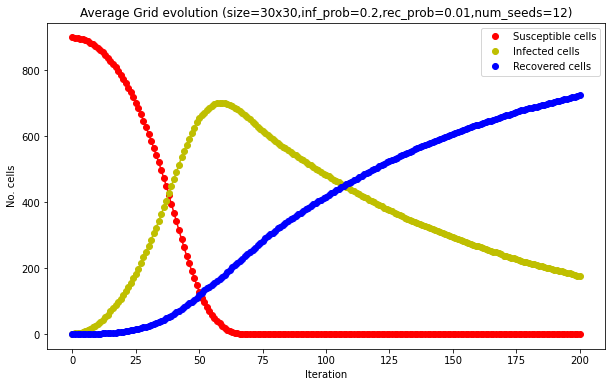

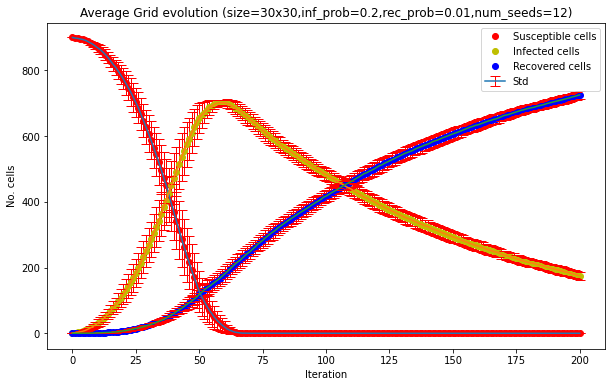

...


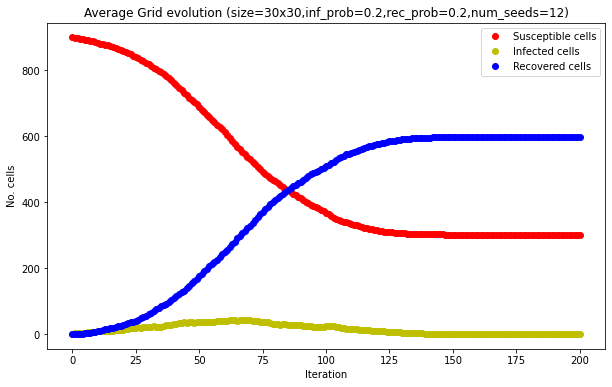

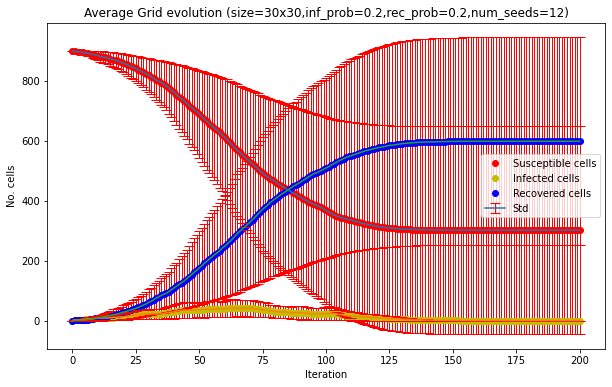

...


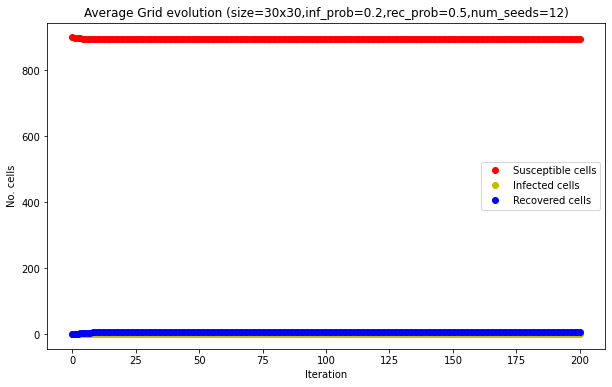

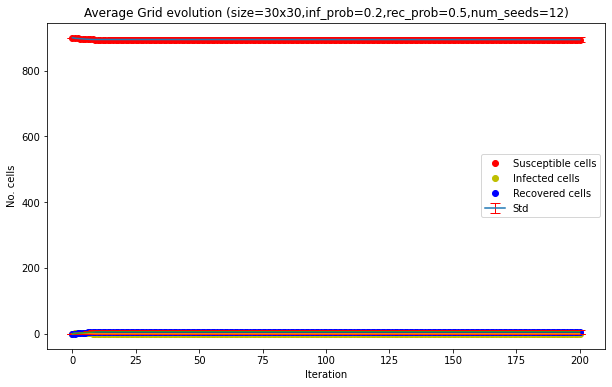

...


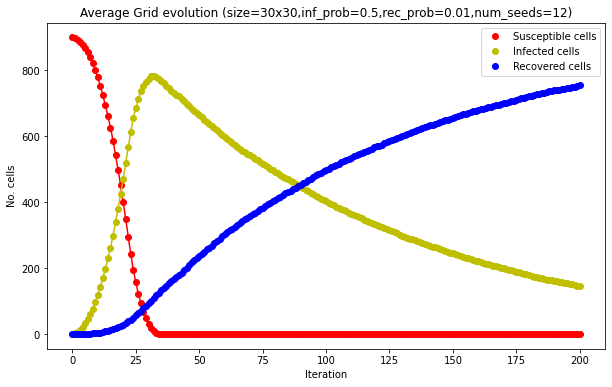

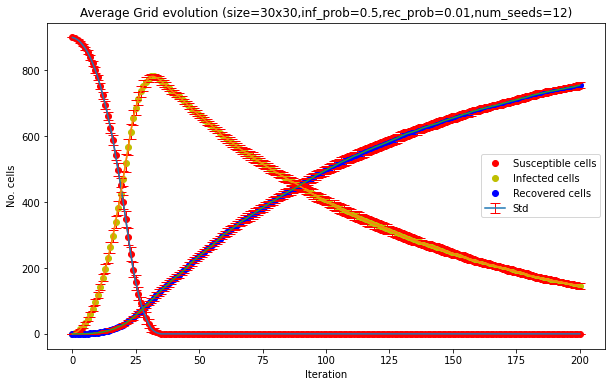

...


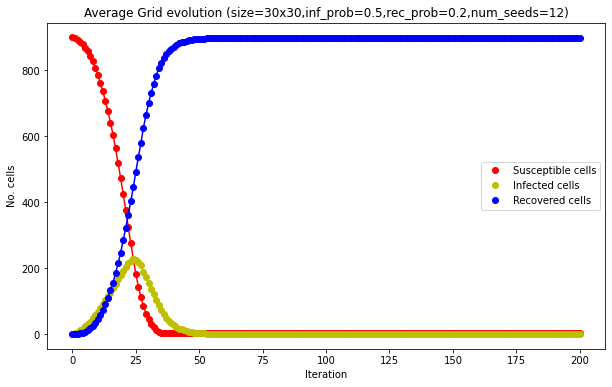

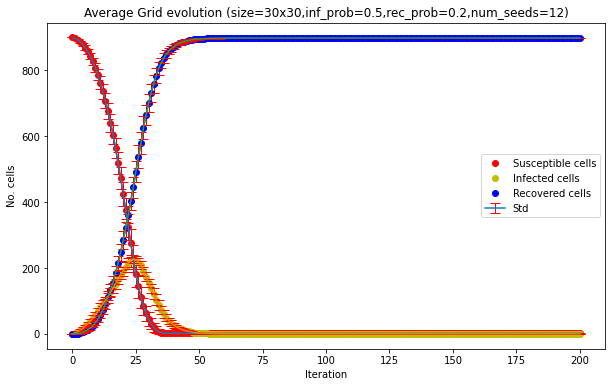

...


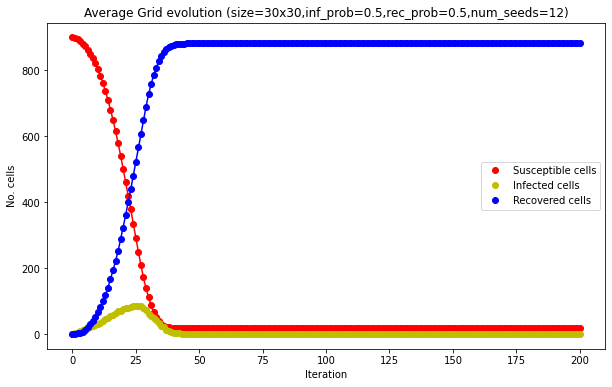

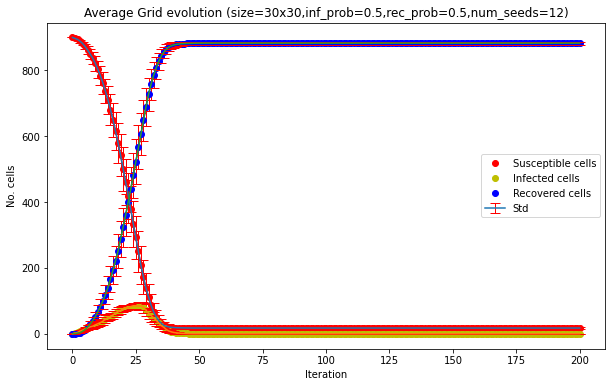

...


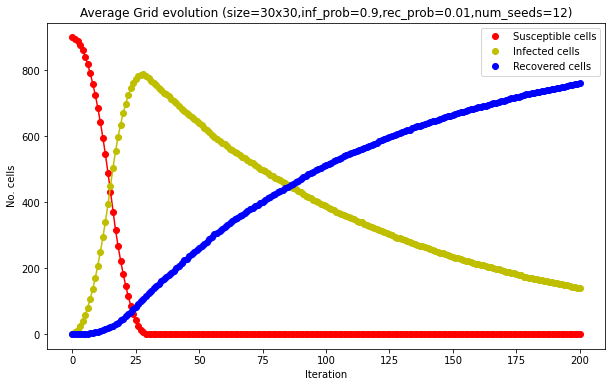

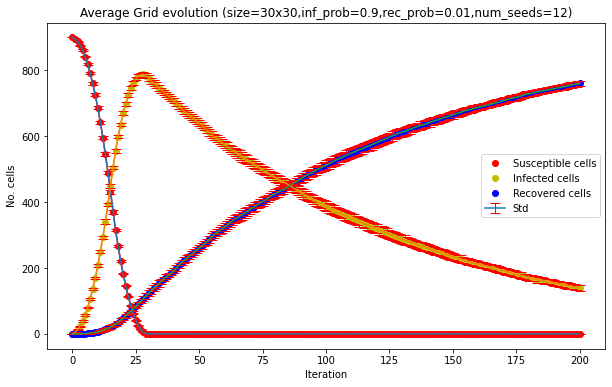

...


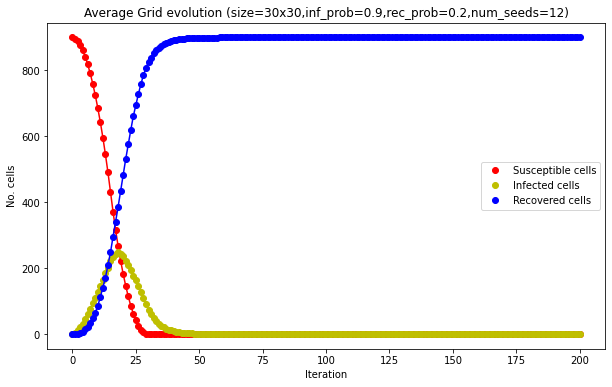

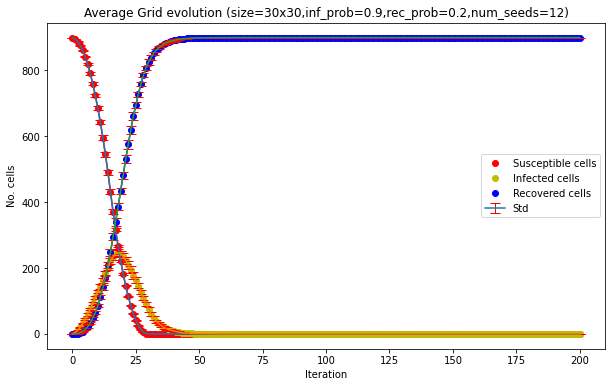

...


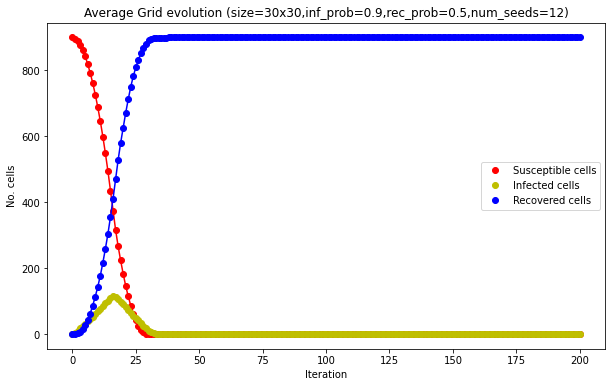

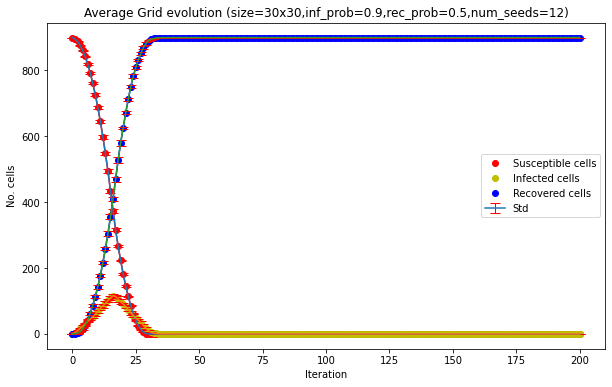

In [18]:
inf_probs = [0.2,0.5,0.9]
rec_probs = [0.01,0.2,0.5]
parameter_combinations = list(itertools.product(inf_probs, rec_probs))

iter_to_plot = [1,20,num_iter]
seeds = np.arange(2010,2022,1)

for inf_prob,rec_prob in tqdm(parameter_combinations):
    print("...")
    susc_hists = []
    inf_hists = []
    rec_hists = []
    for seed in seeds:
        np.random.seed(seed)
        grid = Grid(n_rows,n_cols,susc_id)
        start_infection(grid,num_start_inf,inf_id)

        susc_hist = [grid.num_cells]
        inf_hist = [0]
        rec_hist = [0]

        for curr_iter in range(1,num_iter+1):

            infection_step(grid,inf_prob,rec_prob,inf_id,susc_id)
            susc_hist.append(len(np.where(grid.array == susc_id)[0]))
            inf_hist.append(len(np.where(grid.array == inf_id)[0]))
            rec_hist.append(len(np.where(grid.array == rec_id)[0]))
            
        susc_hists.append(np.array(susc_hist))
        inf_hists.append(np.array(inf_hist))
        rec_hists.append(np.array(rec_hist))
        
    susc_hists = np.array(susc_hists)
    susc_stds = susc_hists.std(axis=0)
    
    inf_hists = np.array(inf_hists)
    inf_stds = inf_hists.std(axis=0)
    
    rec_hists = np.array(rec_hists)
    rec_stds = rec_hists.std(axis=0)
    
    plot_grid_evolution(susc_hists.mean(axis=0),inf_hists.mean(axis=0),rec_hists.mean(axis=0),
                        n_rows,n_cols,inf_prob,rec_prob,len(seeds),False)
    plot_grid_evolution(susc_hists.mean(axis=0),inf_hists.mean(axis=0),rec_hists.mean(axis=0),
                        n_rows,n_cols,inf_prob,rec_prob,len(seeds),True,
                        susc_stds,inf_stds,rec_stds)

* Podemos perceber que o comportamento da grid varia de forma significativa para seeds diferentes, fixando-se os parâmetros.
* A evolução da grid demonstra um comportamento esperado w.r.t. parâmetros

## Experimento 2: Visualizando a evolução da grid para uma seed fixa

In [11]:
n_rows = n_cols =  20
num_iter = 100
num_start_inf = 1

susc_id = 0
inf_id = 1
rec_id = 2

seed = 2022

  0%|          | 0/1 [00:00<?, ?it/s]

...


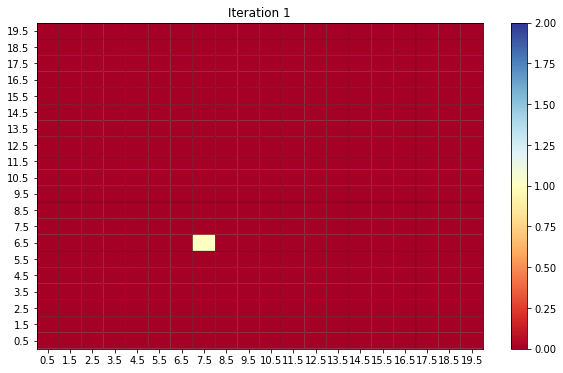

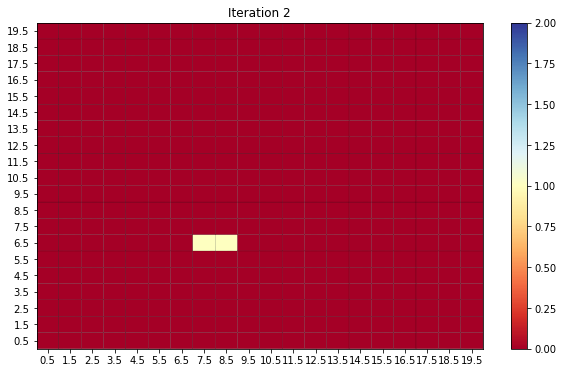

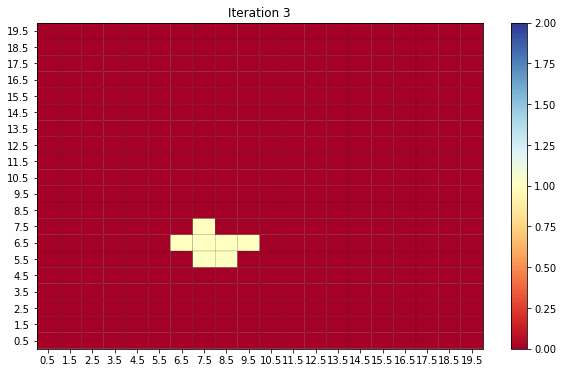

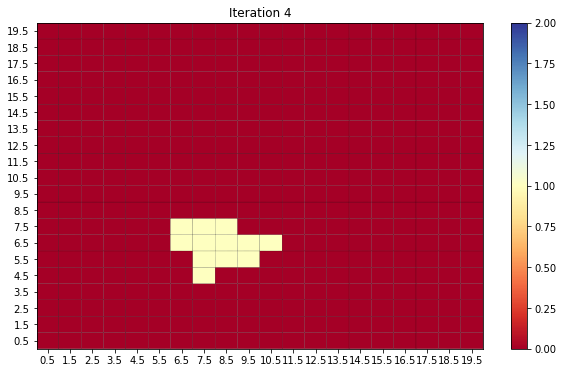

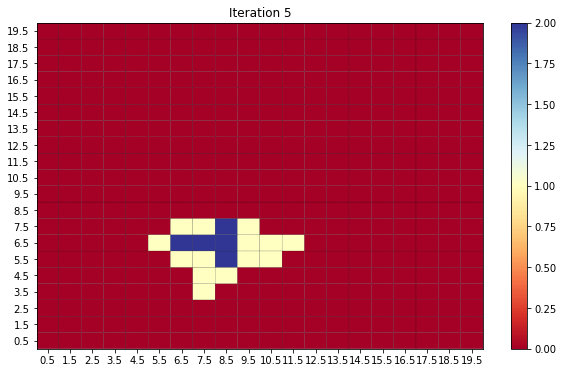

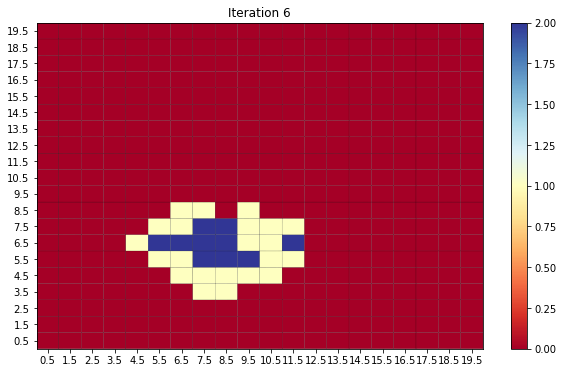

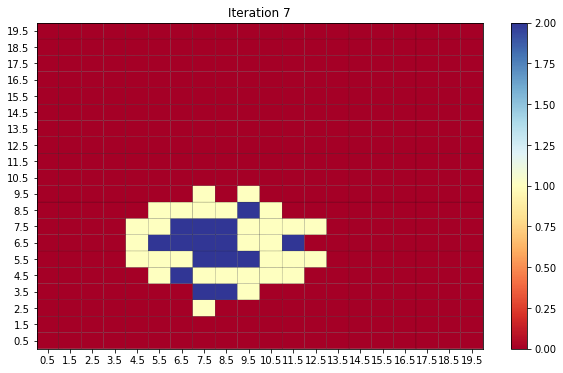

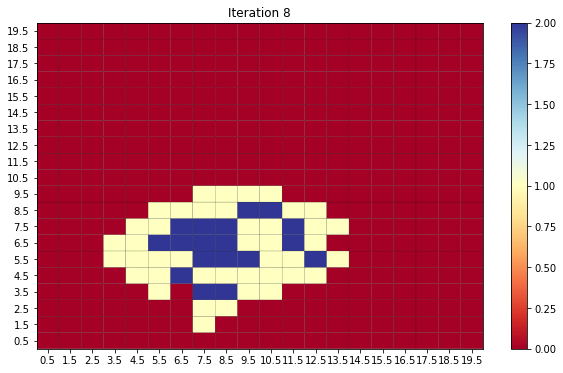

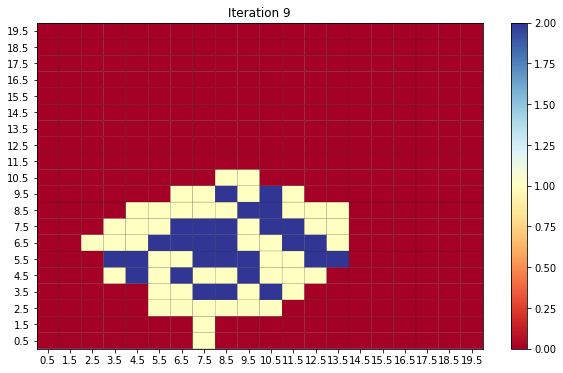

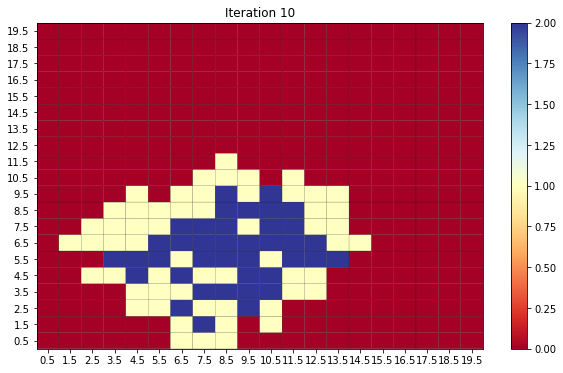

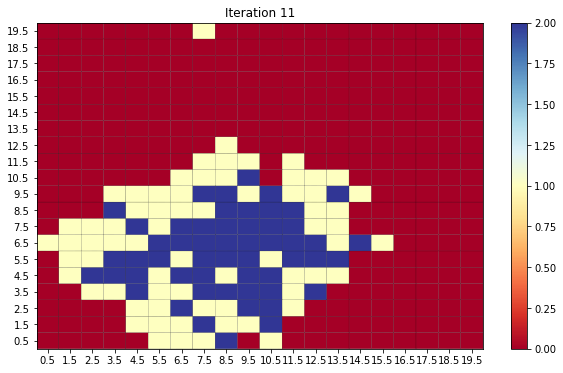

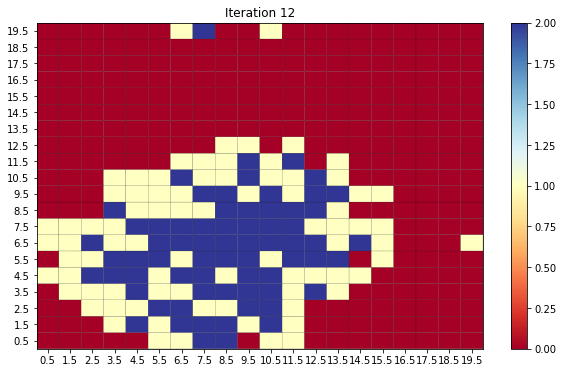

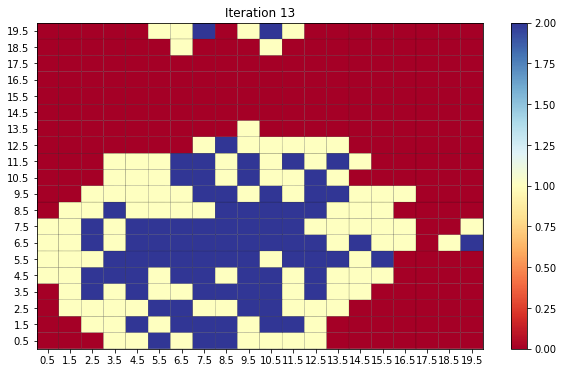

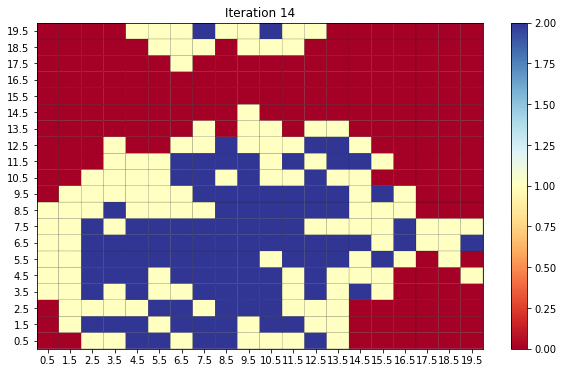

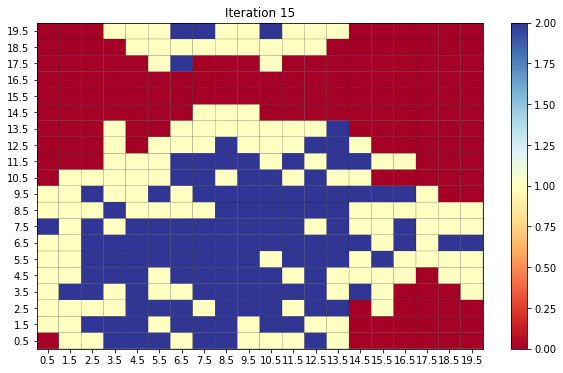

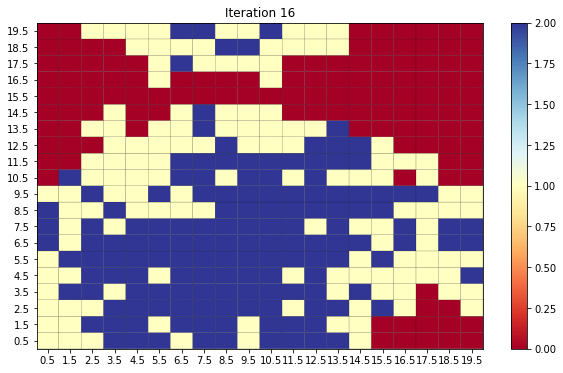

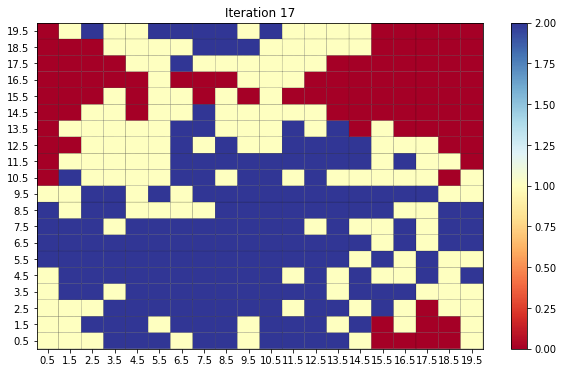

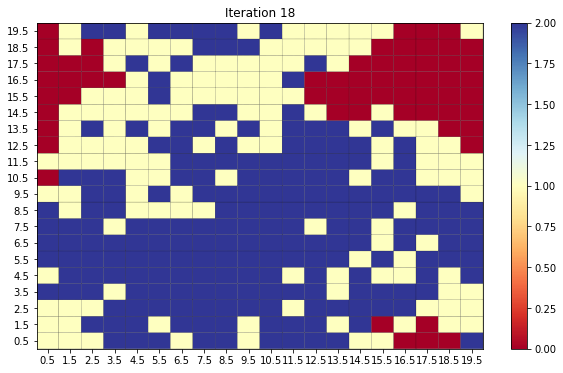

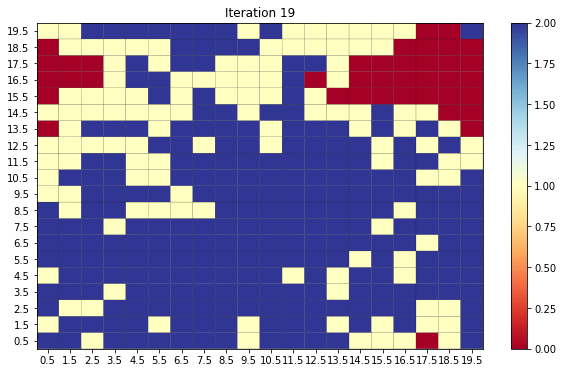

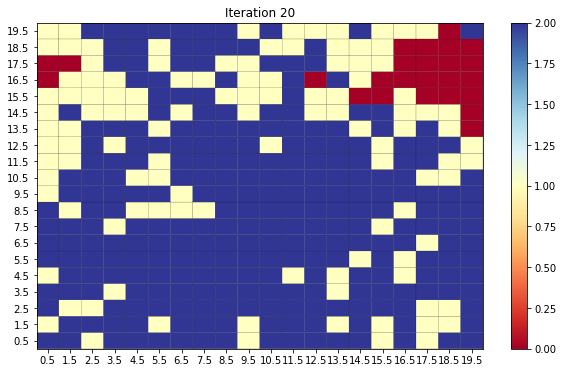

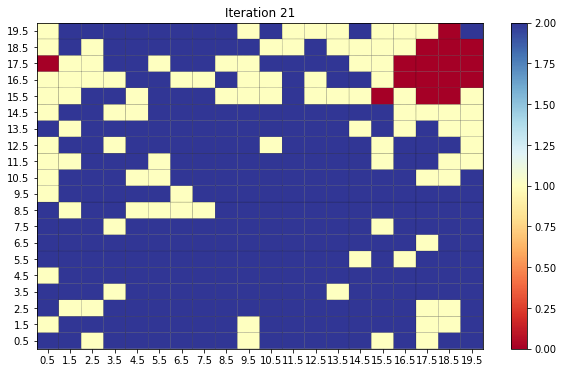

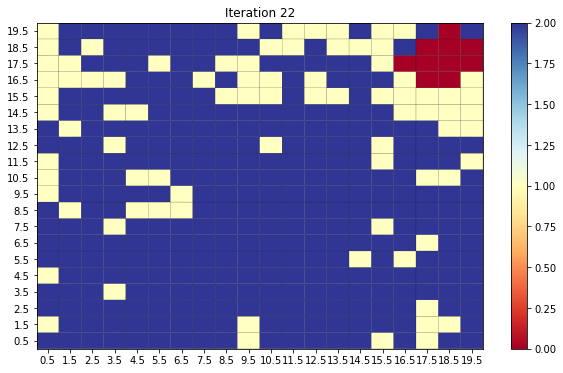

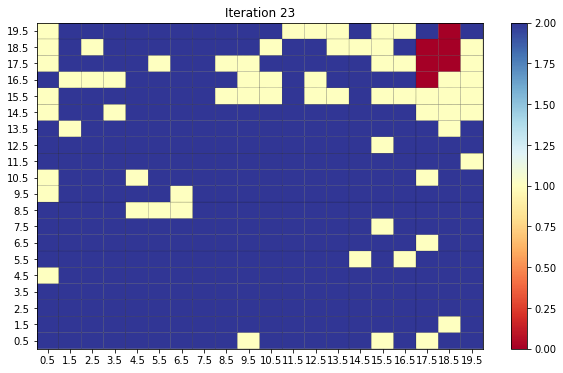

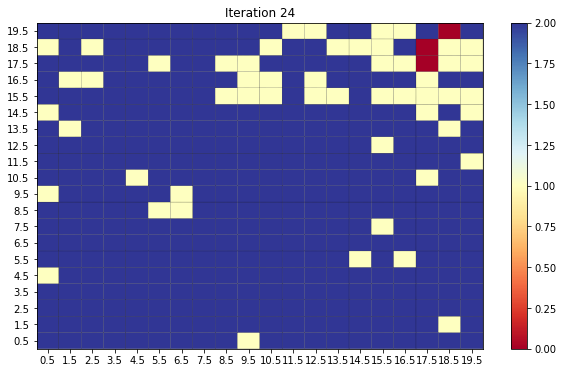

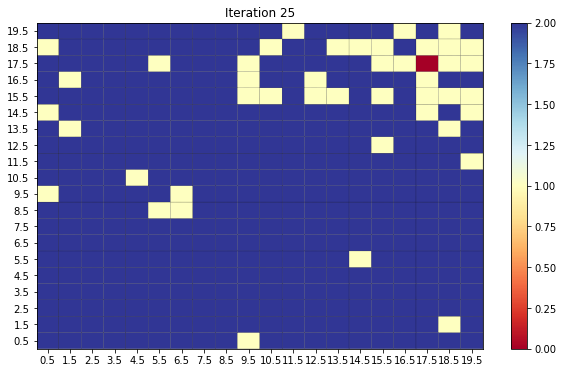

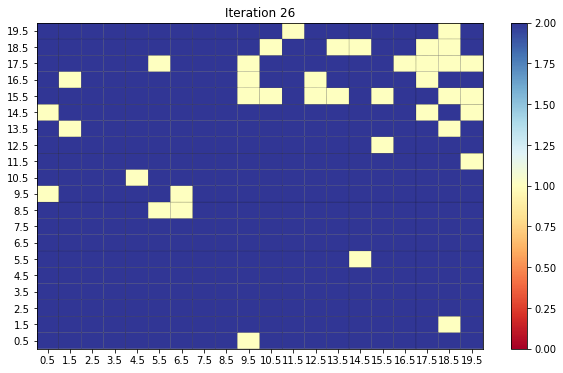

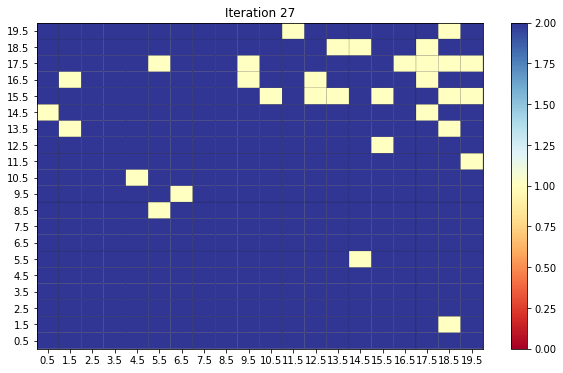

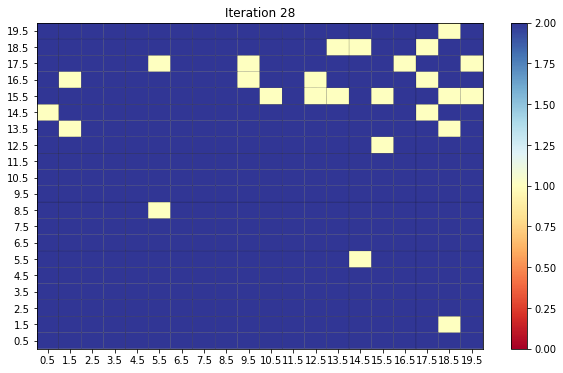

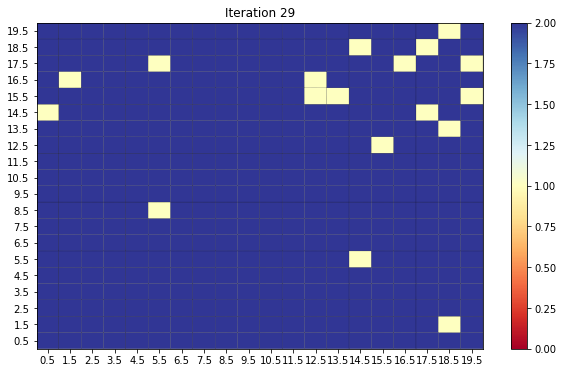

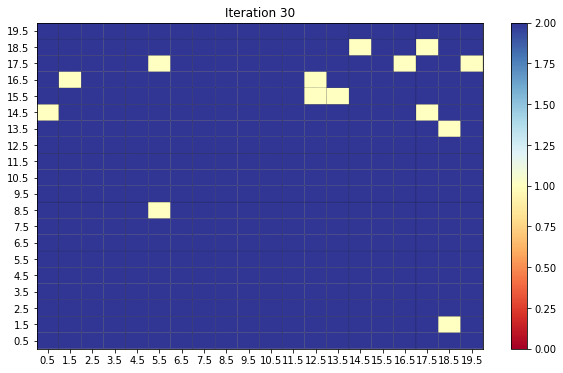

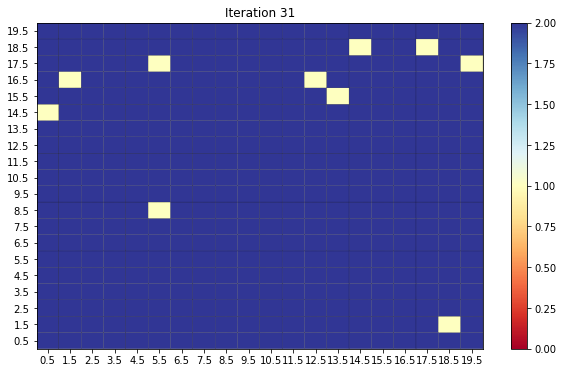

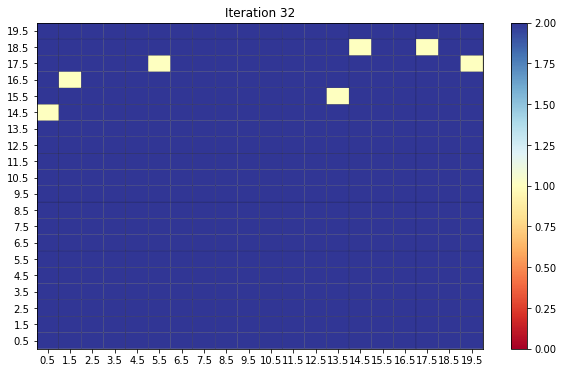

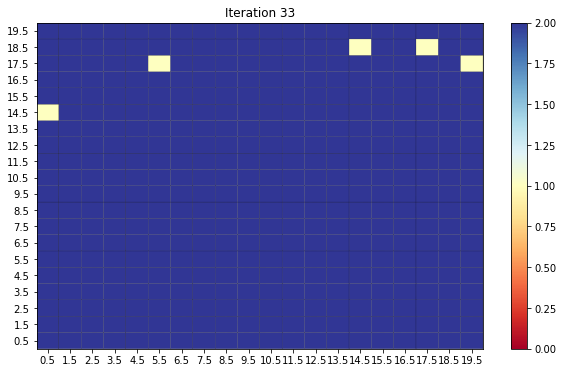

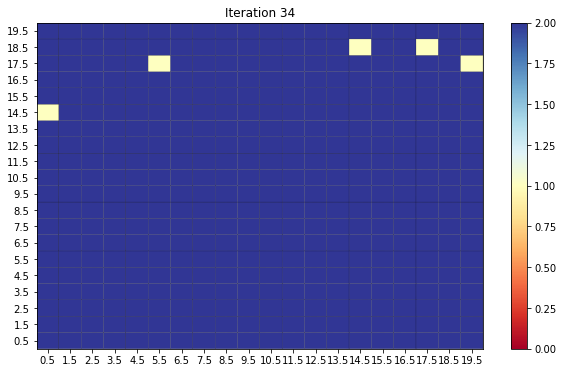

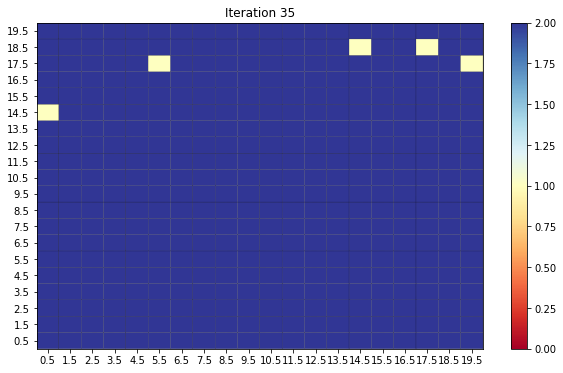

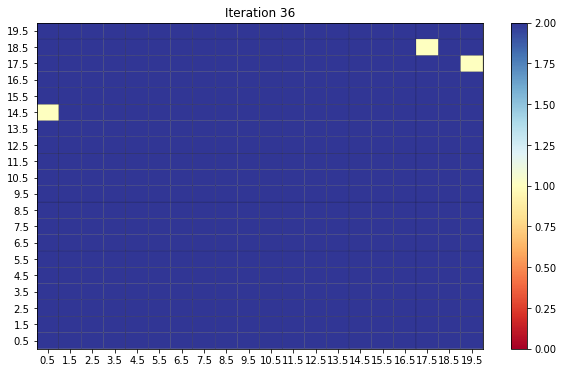

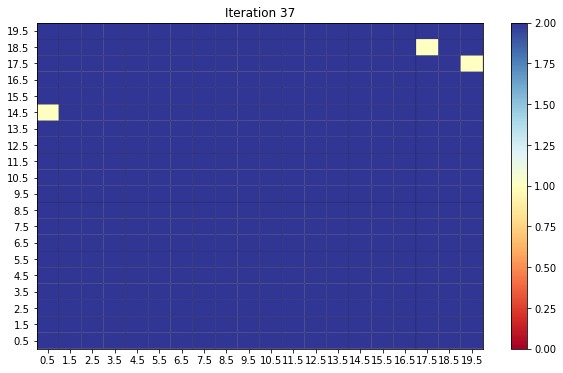

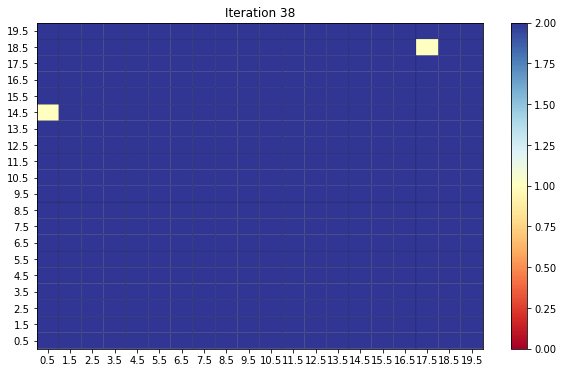

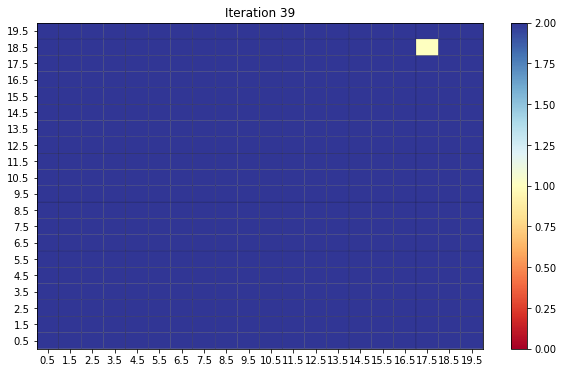

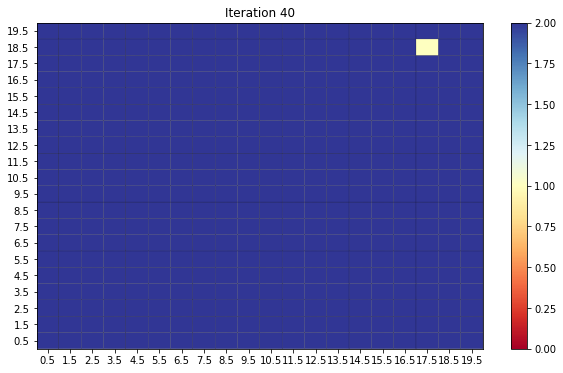

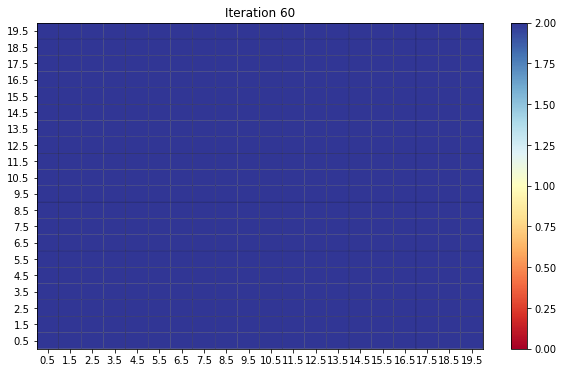

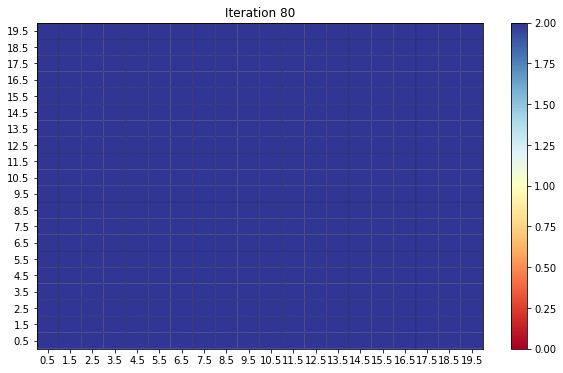

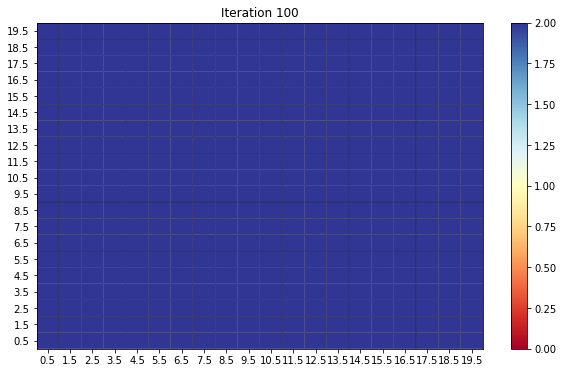

In [12]:
np.random.seed(seed)

inf_probs = [0.5]
rec_probs = [0.2]
parameter_combinations = list(itertools.product(inf_probs, rec_probs))

iter_to_plot = np.concatenate([np.arange(0,40,1),np.arange(40,num_iter+20,20)])

for inf_prob,rec_prob in tqdm(parameter_combinations):
    print("...")
    grid = Grid(n_rows,n_cols,susc_id)
    start_infection(grid,num_start_inf,inf_id)

    susc_hist = [grid.num_cells]
    inf_hist = [0]
    rec_hist = [0]

    for curr_iter in range(1,num_iter+1):
        if curr_iter in iter_to_plot or curr_iter == 1:
            plot_grid(grid,f"Iteration {curr_iter}")

        infection_step(grid,inf_prob,rec_prob,inf_id,susc_id)
        susc_hist.append(len(np.where(grid.array == susc_id)[0]))
        inf_hist.append(len(np.where(grid.array == inf_id)[0]))
        rec_hist.append(len(np.where(grid.array == rec_id)[0]))


